In [1]:
import os
from vae import UserMovieDataset, VAEModel, VAESolver
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

filepath = "../../datasets/ml-20m"

Train Data Sample

In [6]:
# Create the dataset
dataset = UserMovieDataset(os.path.join(filepath, "train.csv"), os.path.join(filepath, "movies.csv"), holdout_split=None)

# Create a DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example: Iterate through the DataLoader
for user_ids, user_vectors in dataloader:
    print("User IDs:", user_ids)
    print("Train table:", user_vectors)
    print("Train table shape: ", user_vectors.shape)
    break

User IDs: tensor([ 99720,  23888, 134113,  55102,  47656,  54594,  90978,   5079,  34546,
         71530,  36991,  76665,  90028,  92785,  75611,  59064, 102559, 122084,
         90676,  91310,  56491,  69125,  33813,  90269,  72341,   4722,  25092,
        107090,  70674,  45004,  74868,  36524])
Train table: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Train table shape:  torch.Size([32, 27278])


Test Data Sample

The Inference Table and Test Table share the same user IDs. The Inference Table contains the first 80% of each user's movie interactions, used during the forward pass, while the Test Table contains the most recent 20% of interactions. The model's goal is to assign high ranks to the movies seen in the Test Table.

In [2]:
# Create the dataset
dataset = UserMovieDataset(os.path.join(filepath, "test.csv"), os.path.join(filepath, "movies.csv"))

# Create a DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example: Iterate through the DataLoader
for user_ids, inference_vector, test_vector in dataloader:
    print("User IDs:", user_ids)
    print("Inference table:", inference_vector)
    print("Inference table shape: ", inference_vector.shape)
    print("Test table:", test_vector)
    print("Test table shape: ", test_vector.shape)
    break

User IDs: tensor([ 73515,  31509,  10870, 137981,  40103,   7996, 124076,  58578, 115939,
        135191,  71831,  14476, 120993,  85797, 119798,  60571,  14210,  94046,
         63072, 106626,  22947,  66769,  73382,   6303,  86272,  68538,  48467,
         53232,  43204,   3462,  88799, 124108])
Inference table: tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Inference table shape:  torch.Size([32, 27278])
Test table: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Test table shape:  torch.Size([32, 27278])


In [ ]:
# solver params
device = "mps" # mps | cuda | cpu
epochs = 16 # section 4.3
batch_size = 500 # section 4.3
lam = 0.01 # VAE paper official Git implementation
checkpoint_dir = "./checkpoints"

# Create Model
input_size = 27278
hidden_size = 600
K = 200
model = VAEModel(identity_size=input_size, hidden_size = hidden_size, K = K)
model.to(device)

# Create dataset
train_data = UserMovieDataset(
                                datapath = os.path.join(filepath, "train.csv"), 
                                moviepath = os.path.join(filepath, "movies.csv"), 
                                holdout_split=None, 
                                device = device
                            )

vae_solver = VAESolver(
                    device = device,
                    epochs = epochs,
                    batch_size = batch_size,
                    num_workers = 8,
                    checkpoint_dir = checkpoint_dir,
                    model = model,
                    data = train_data,
                    print_every = 1,
                    wandb_api = None,
                    reset = True,
                    lr = 1e-3,
                    anneal_steps = 200000,
                    anneal_cap = 0.2,
                    lam = lam
                )

vae_solver.train()

wandb: Currently logged in as: paataugrekhelidze (paataugrekhelidze-phasislabs) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Bottleneck is the dataloader

Graph of training time per epoch for different # of workers assigned to the dataloader

In [ ]:
workers = [0, 4, 6, 8, 10]
time_per_epoch = [20, 6.3, 5.5, 5, 4.98]

plt.plot(workers, time_per_epoch)
plt.xlabel("workers")
plt.ylabel("time per epoch (min)")
plt.title("Train Time per Epoch vs Num Workers")

In [ ]:
# Plot the training losses.
plt.plot(vae_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [ ]:
import torch
import os
import torch.nn.functional as F
from vae import recall_at_r, ndcg_at_r


# calculate recall@20
# 80% of the history of the val/test data will be used for inference 
# 20% of the history of the val/test data will be the target that the model should recommend in top K

device = "mps" # mps | cuda | cpu
checkpoint_dir = "./checkpoints"
R = 20
batch_size = 2000

# Create Model
input_size = 27278
hidden_size = 600
K = 200
model = VAEModel(identity_size=input_size, hidden_size = hidden_size, K = K)
model.to(device)
model.eval()

recall_history = []
ndcg_history = []
epochs = [x for x in range(0, 101, 5)]
for epoch in epochs:
    checkpoint = torch.load(os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth"), map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    #loss = checkpoint["loss"]

    # Create the dataset
    val_data = UserMovieDataset(
                                datapath = os.path.join(filepath, "val.csv"), 
                                moviepath = os.path.join(filepath, "movies.csv"),
                                # 80% of the history of the val/test data will be used for inference 
                                # 20% of the history of the val/test data will be the target that the model should recommend in top R
                                holdout_split=0.8, 
                                device = device
                            )

    # Create a DataLoader for batch processing
    dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers = 8)

    total_recall = 0
    total_ndcg = 0
    total_users = 0
    for _, X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(X)
            # MASKING: Prevent the model from recommending items already in the input history
            logits[X == 1] = -float("inf")
            predicted = F.softmax(logits, dim=1)
        
        # recall
        sum_recall, users = recall_at_r(predicted = predicted, actual = y, R = R)
        total_users += users
        total_recall += sum_recall

        # ndcg
        sum_ndcg, _ = ndcg_at_r(predicted = predicted, actual = y, R = R, device = device)
        total_ndcg += sum_ndcg

    avg_recall = total_recall / total_users # avg recall per user
    avg_ndcg = total_ndcg / total_users # avg ndcg per user
    recall_history.append(avg_recall)
    ndcg_history.append(avg_ndcg)
    print(f"Epoch [{epoch}] - Recall@{R}: {avg_recall:.2f} | NDCG@{R}: {avg_ndcg:.2f}")

    

Epoch [0] - Recall@20: 0.14 | NDCG@20: 0.11
Epoch [5] - Recall@20: 0.17 | NDCG@20: 0.13
Epoch [10] - Recall@20: 0.17 | NDCG@20: 0.13
Epoch [15] - Recall@20: 0.17 | NDCG@20: 0.14
Epoch [20] - Recall@20: 0.17 | NDCG@20: 0.13
Epoch [25] - Recall@20: 0.17 | NDCG@20: 0.13
Epoch [30] - Recall@20: 0.17 | NDCG@20: 0.13
Epoch [35] - Recall@20: 0.17 | NDCG@20: 0.13
Epoch [40] - Recall@20: 0.17 | NDCG@20: 0.13
Epoch [45] - Recall@20: 0.17 | NDCG@20: 0.14
Epoch [50] - Recall@20: 0.17 | NDCG@20: 0.14
Epoch [55] - Recall@20: 0.17 | NDCG@20: 0.14
Epoch [60] - Recall@20: 0.17 | NDCG@20: 0.14
Epoch [65] - Recall@20: 0.17 | NDCG@20: 0.14
Epoch [70] - Recall@20: 0.18 | NDCG@20: 0.14
Epoch [75] - Recall@20: 0.17 | NDCG@20: 0.14
Epoch [80] - Recall@20: 0.18 | NDCG@20: 0.14
Epoch [85] - Recall@20: 0.17 | NDCG@20: 0.14
Epoch [90] - Recall@20: 0.17 | NDCG@20: 0.14
Epoch [95] - Recall@20: 0.17 | NDCG@20: 0.14
Epoch [100] - Recall@20: 0.17 | NDCG@20: 0.14


Text(0.5, 1.0, 'Avg ndcg@20 vs epoch')

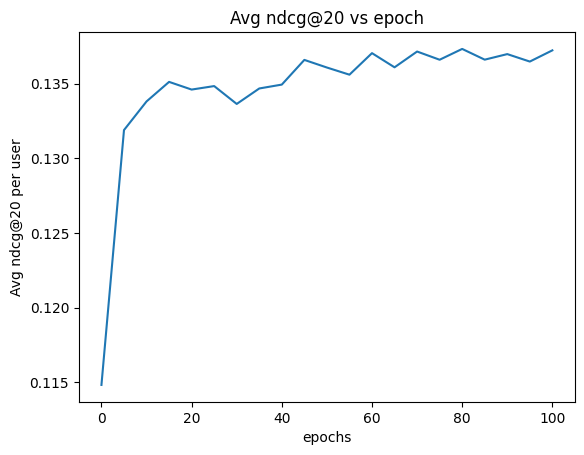

In [3]:
plt.plot(epochs, ndcg_history)
plt.xlabel("epochs")
plt.ylabel(f"Avg ndcg@{R} per user")
plt.title(f"Avg ndcg@{R} vs epoch")



Text(0.5, 1.0, 'Avg recall@20 vs epoch')

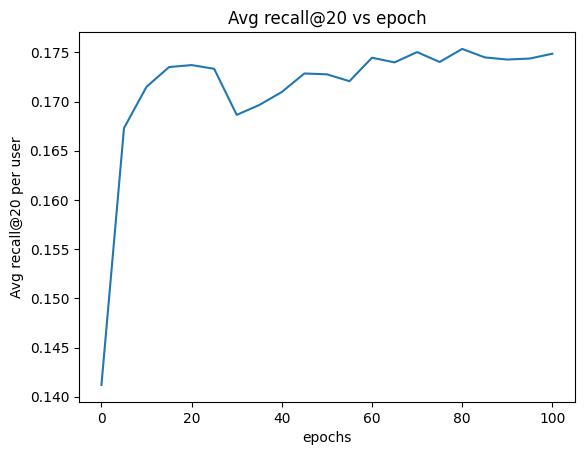

In [4]:
plt.plot(epochs, recall_history)
plt.xlabel("epochs")
plt.ylabel(f"Avg recall@{R} per user")
plt.title(f"Avg recall@{R} vs epoch")

In [20]:
import torch.nn.functional as F
import torch

device = "cpu"
checkpoint_dir = "./checkpoints"

# load last checkpoint
model = VAEModel(identity_size=27278, hidden_size = 600, K = 200)
model.to(device)
model.eval()

checkpoint = torch.load(os.path.join(checkpoint_dir, f"last_checkpoint.pth"), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])


# Create the dataset
test_data = UserMovieDataset(
                                datapath = os.path.join(filepath, "test.csv"), 
                                moviepath = os.path.join(filepath, "movies.csv"),
                                # 80% of the history of the val/test data will be used for inference 
                                # 20% of the history of the val/test data will be the target that the model should recommend in top R
                                holdout_split=0.8, 
                                device = device
                            )


# Create a DataLoader for batch processing
dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

# Example: Iterate through the DataLoader
for user_ids, X, Y in dataloader:
    X = X.to(device)
    Y = Y.to(device)
    with torch.no_grad():
        logits = model(X)
        # MASKING: Prevent the model from recommending items already in the input history
        # logits[X == 1] = -float("inf")
        predicted = F.softmax(logits, dim=1)
            
    X_df, _ = test_data.vector_to_df(data=X, R = 100)
    Y_df, _ = test_data.vector_to_df(data=Y, R = 100)
    predicted_df, predicted_probs_df = test_data.vector_to_df(data=predicted, R = 100)

    break

In [21]:
# user history that the model gets
X_df.head()

,userId,movie 0,movie 1,movie 2,movie 3,movie 4,movie 5,movie 6,movie 7,movie 8,...,movie 90,movie 91,movie 92,movie 93,movie 94,movie 95,movie 96,movie 97,movie 98,movie 99
0,24,Broken Arrow (1996),Toy Story (1995),Cocktail (1988),Bat*21 (1988),Point Break (1991),Heat (1995),All the Pretty Horses (2000),Finding Forrester (2000),Unbreakable (2000),...,"Wedding Singer, The (1998)",Titanic (1997),Good Will Hunting (1997),"Prophecy, The (1995)","Jackal, The (1997)","Truman Show, The (1998)",Sliding Doors (1998),Starship Troopers (1997),Boogie Nights (1997),Gattaca (1997)
1,34,"Indian in the Cupboard, The (1995)",Toy Story (1995),Twister (1996),Pretty Woman (1990),Beauty and the Beast (1991),Batman (1989),Terminator 2: Judgment Day (1991),Aladdin (1992),Ghost (1990),...,None,None,None,None,None,None,None,None,None,None
2,45,Gone with the Wind (1939),Art School Confidential (2006),"Station Agent, The (2003)",Monsoon Wedding (2001),"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Office Space (1999),Chinatown (1974),"Women, The (1939)",All About Eve (1950),...,None,None,None,None,None,None,None,None,None,None
3,90,Seven (a.k.a. Se7en) (1995),Batman Begins (2005),Hide and Seek (2005),Spider-Man 2 (2004),Harry Potter and the Prisoner of Azkaban (2004),Shrek 2 (2004),Kill Bill: Vol. 2 (2004),Kill Bill: Vol. 1 (2003),Finding Nemo (2003),...,None,None,None,None,None,None,None,None,None,None
4,111,Hocus Pocus (1993),Juno (2007),Knocked Up (2007),Stranger than Fiction (2006),"40-Year-Old Virgin, The (2005)","Notebook, The (2004)",Barbershop (2002),"Hurricane, The (1999)",Sixteen Candles (1984),...,None,None,None,None,None,None,None,None,None,None


In [22]:
# target later user history not shown to the model
Y_df.head()

,userId,movie 0,movie 1,movie 2,movie 3,movie 4,movie 5,movie 6,movie 7,movie 8,...,movie 90,movie 91,movie 92,movie 93,movie 94,movie 95,movie 96,movie 97,movie 98,movie 99
0,24,"Ref, The (1994)",Tears of the Sun (2003),"Ring, The (2002)",Red Dragon (2002),Road to Perdition (2002),"Bourne Identity, The (2002)",About a Boy (2002),My Big Fat Greek Wedding (2002),"Beautiful Mind, A (2001)",...,None,None,None,None,None,None,None,None,None,None
1,34,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Eraser (1996),Independence Day (a.k.a. ID4) (1996),"Rock, The (1996)","Truth About Cats & Dogs, The (1996)",Mission: Impossible (1996),"River Wild, The (1994)",Only You (1994),Little Women (1994),...,None,None,None,None,None,None,None,None,None,None
2,45,"Nightmare Before Christmas, The (1993)",Tokyo Godfathers (2003),Talk to Her (Hable con Ella) (2002),"Now, Voyager (1942)",Auntie Mame (1958),Edward Scissorhands (1990),None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,90,"Birdcage, The (1996)",X-Men: The Last Stand (2006),Crash (2004),Meet the Parents (2000),Who Framed Roger Rabbit? (1988),American Pie (1999),"South Park: Bigger, Longer and Uncut (1999)",Beetlejuice (1988),Back to the Future Part III (1990),...,None,None,None,None,None,None,None,None,None,None
4,111,"Shawshank Redemption, The (1994)",Talladega Nights: The Ballad of Ricky Bobby (2...,Schindler's List (1993),None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [23]:
# predicted recommendations, sorted most to least likely
predicted_df.head()

,userId,movie 0,movie 1,movie 2,movie 3,movie 4,movie 5,movie 6,movie 7,movie 8,...,movie 90,movie 91,movie 92,movie 93,movie 94,movie 95,movie 96,movie 97,movie 98,movie 99
0,24,Saving Private Ryan (1998),Gladiator (2000),Braveheart (1995),Pulp Fiction (1994),Forrest Gump (1994),"Matrix, The (1999)",Terminator 2: Judgment Day (1991),There's Something About Mary (1998),"Shawshank Redemption, The (1994)",...,Titanic (1997),Liar Liar (1997),Speed (1994),Varsity Blues (1999),My Cousin Vinny (1992),Boiler Room (2000),Scary Movie (2000),"Me, Myself & Irene (2000)",Ace Ventura: Pet Detective (1994),Léon: The Professional (a.k.a. The Professiona...
1,34,"Santa Clause, The (1994)",Mrs. Doubtfire (1993),"Fugitive, The (1993)",Sleepless in Seattle (1993),True Lies (1994),"Lion King, The (1994)",Jurassic Park (1993),Dave (1993),Apollo 13 (1995),...,Beverly Hills Cop III (1994),"Piano, The (1993)",Cliffhanger (1993),Under Siege 2: Dark Territory (1995),"Aristocats, The (1970)",Coneheads (1993),Seven (a.k.a. Se7en) (1995),Demolition Man (1993),Nine Months (1995),Father of the Bride Part II (1995)
2,45,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Casablanca (1942),American Beauty (1999),Eternal Sunshine of the Spotless Mind (2004),Annie Hall (1977),Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),All About Eve (1950),Some Like It Hot (1959),"Maltese Falcon, The (1941)",...,Say Anything... (1989),Talk to Her (Hable con Ella) (2002),"400 Blows, The (Les quatre cents coups) (1959)",Cinema Paradiso (Nuovo cinema Paradiso) (1989),"Apartment, The (1960)",Schindler's List (1993),"Wizard of Oz, The (1939)",Sabrina (1954),Elizabeth (1998),City of God (Cidade de Deus) (2002)
3,90,Shrek (2001),"Lion King, The (1994)",Toy Story (1995),Shrek 2 (2004),Aladdin (1992),Finding Nemo (2003),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Fellowship of the Ring,...","Incredibles, The (2004)",...,"Last Samurai, The (2003)","Truman Show, The (1998)",Big Fish (2003),American History X (1998),Dumb & Dumber (Dumb and Dumber) (1994),Home Alone (1990),Good Will Hunting (1997),Babe (1995),Star Wars: Episode III - Revenge of the Sith (...,Office Space (1999)
4,111,"40-Year-Old Virgin, The (2005)",Juno (2007),Little Miss Sunshine (2006),Knocked Up (2007),Superbad (2007),Forgetting Sarah Marshall (2008),10 Things I Hate About You (1999),"Shawshank Redemption, The (1994)",Garden State (2004),...,"Bourne Identity, The (2002)","Godfather, The (1972)","Monsters, Inc. (2001)",Pineapple Express (2008),School of Rock (2003),28 Days (2000),"Lord of the Rings: The Return of the King, The...","Royal Tenenbaums, The (2001)",Step Brothers (2008),Donnie Darko (2001)


In [27]:
predicted_probs_df

tensor([[0.0080, 0.0080, 0.0077,  ..., 0.0025, 0.0025, 0.0024],
        [0.0210, 0.0205, 0.0185,  ..., 0.0033, 0.0032, 0.0031],
        [0.0157, 0.0148, 0.0139,  ..., 0.0022, 0.0022, 0.0022],
        ...,
        [0.0410, 0.0349, 0.0343,  ..., 0.0018, 0.0018, 0.0017],
        [0.0534, 0.0526, 0.0507,  ..., 0.0005, 0.0005, 0.0005],
        [0.0105, 0.0104, 0.0103,  ..., 0.0022, 0.0022, 0.0022]])

In [3]:
import pandas as pd
import math
loss = 235781
train_df = pd.read_csv(os.path.join(filepath, "train.csv"))
total_users = len(train_df["userId"].unique())
avg_click = train_df.groupby('userId')['click'].sum().mean()
loss_per_user = 479.192508
log_loss_per_prediction = loss_per_user / avg_click
avg_prediction = math.exp(-log_loss_per_prediction)

print(f"Unique users: {total_users}")
print(f"Avg movie clicks per user: {avg_click}")
print(f"Avg loss per user: {loss_per_user}")
print(f"average log loss per prediction: {log_loss_per_prediction}")
print(f"average prediction for a true positive: {avg_prediction}")

Unique users: 118493
Avg movie clicks per user: 72.04672005941279
Avg loss per user: 479.192508
average log loss per prediction: 6.651135646492129
average prediction for a true positive: 0.0012925533879308462


Average prediction of 0.0013 for a true label is terrible!!!!